In [2]:
import torchvision
from torchvision import transforms
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np

from Helper import load_checkpoint_generic, save_checkpoint_generic
from Model import FlyingChairsDataset, MPISintelDataset
from Model import FlowNet



In [3]:
root = r"C:\Users\simon\Desktop\RV\Racunalniski-Vid\RV-N3\datasets\FlyingChairs_release"
# root = r"E:\datasets\FlyingChairs_release"

# transform = transforms.ToTensor()
# transform = None
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = FlyingChairsDataset(root=root, transform=transform, split="val")
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

imgs, flows = next(iter(loader))
print(imgs.shape, flows.shape)


torch.Size([16, 6, 256, 256]) torch.Size([16, 2, 256, 256])


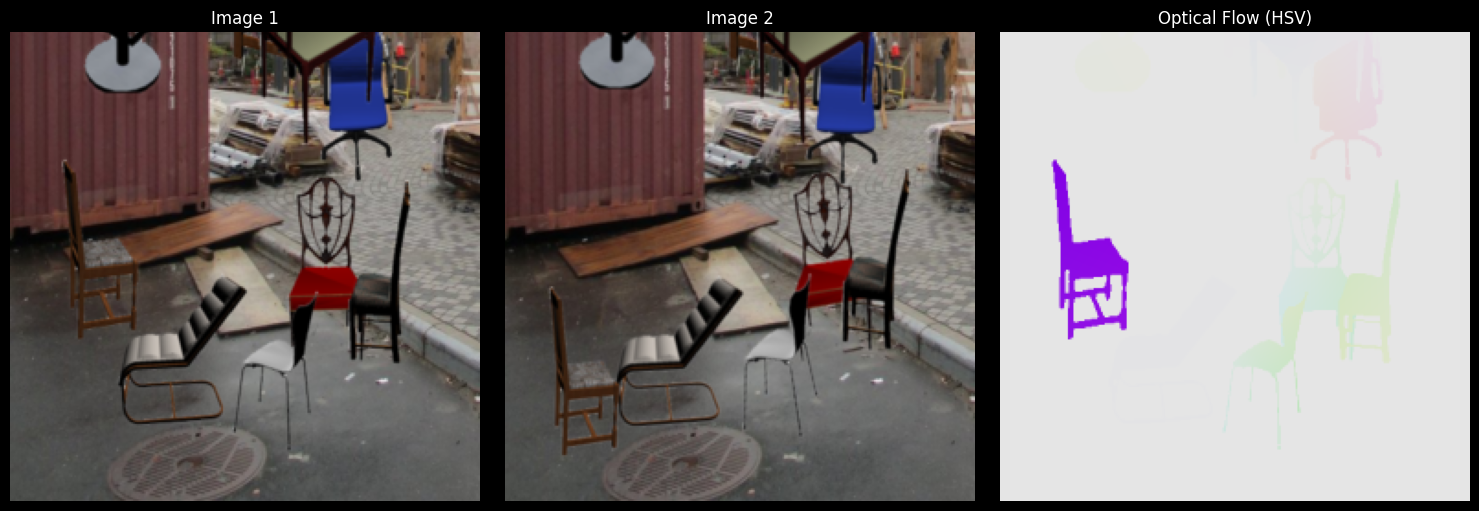

In [4]:
imgs, flows = next(iter(loader))

# Extract first sample from batch
img_pair = imgs[0]  # Shape: (6, H, W)
flow = flows[0]  # Shape: (2, H, W)

# Split the 6-channel image into two 3-channel images
img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)

# Convert flow to numpy (H, W, 2)
flow_np = flow.permute(1, 2, 0).cpu().numpy()

# Split flow components
u = flow_np[:, :, 0]
v = flow_np[:, :, 1]

# Magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)  # [-pi, pi]

# Normalize for HSV
h = (ang + np.pi) / (2 * np.pi)  # hue ∈ [0,1]
s = np.clip(mag / (mag.max() + 1e-6), 0, 1)  # saturation ∈ [0,1]
v_ = np.ones_like(s) * 0.9  # brightness

# Build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)

# Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image 1")
plt.imshow(img1)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image 2")
plt.imshow(img2)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Optical Flow (HSV)")
plt.imshow(rgb_flow)
plt.axis("off")

plt.tight_layout()
plt.show()

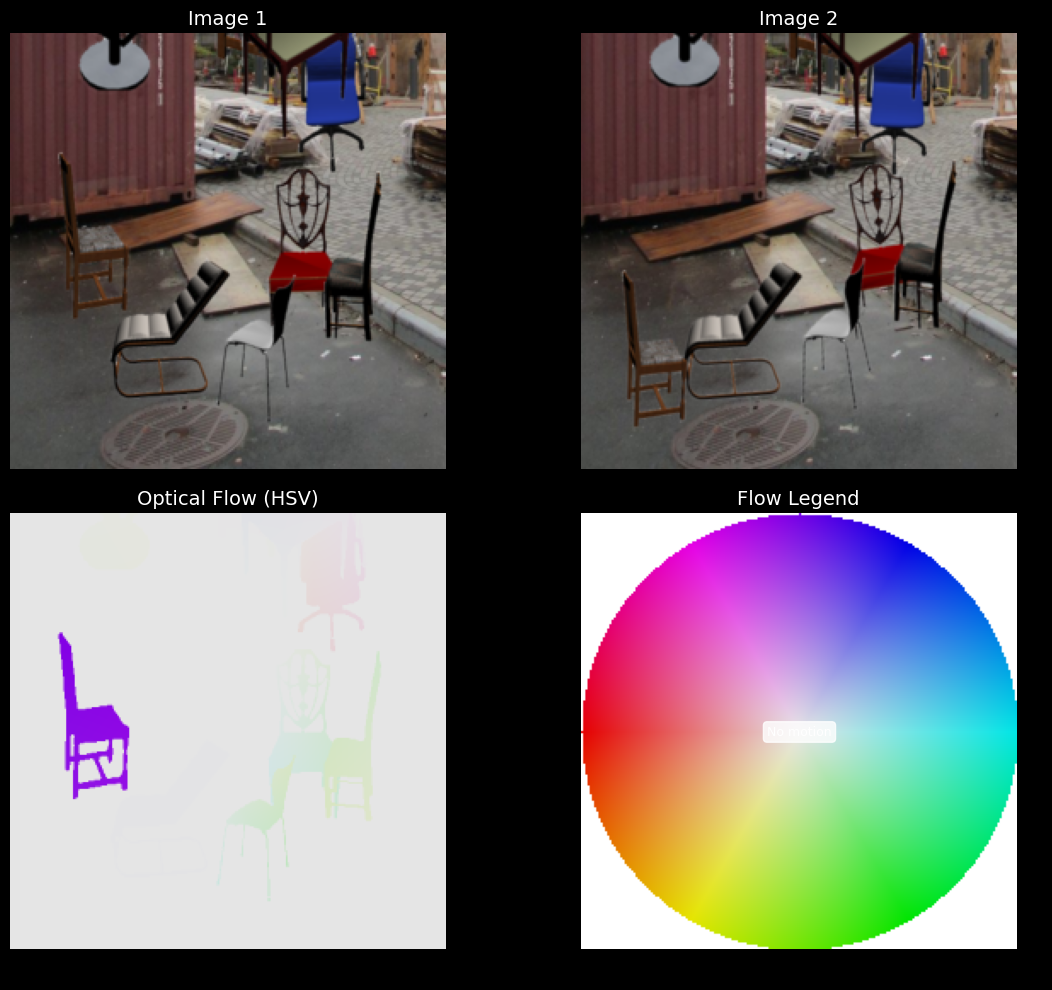

Flow magnitude range: [0.01, 69.33] pixels
Mean flow magnitude: 1.88 pixels


In [5]:
# Extract first sample from batch
img_pair = imgs[0]
flow = flows[0]

# Split images and convert to numpy
img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()
img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()
flow_np = flow.permute(1, 2, 0).cpu().numpy()

# Split flow components
u = flow_np[:, :, 0]
v = flow_np[:, :, 1]

# Magnitude and angle
mag = np.sqrt(u ** 2 + v ** 2)
ang = np.arctan2(v, u)

# Normalize for HSV
h = (ang + np.pi) / (2 * np.pi)
s = np.clip(mag / (mag.max() + 1e-6), 0, 1)
v_ = np.ones_like(s) * 0.9

# Build HSV image
hsv = np.stack([h, s, v_], axis=-1)
rgb_flow = mcolors.hsv_to_rgb(hsv)


# --- Create colorwheel legend ---
def make_colorwheel(size=256):
    """Create a colorwheel showing flow direction and magnitude"""
    y, x = np.mgrid[-size // 2:size // 2, -size // 2:size // 2]

    angle = np.arctan2(-y, x)
    radius = np.sqrt(x ** 2 + y ** 2)

    hue = (angle + np.pi) / (2 * np.pi)
    saturation = np.clip(radius / (size // 2), 0, 1)
    value = np.ones_like(saturation) * 0.9

    hsv_wheel = np.stack([hue, saturation, value], axis=-1)
    rgb_wheel = mcolors.hsv_to_rgb(hsv_wheel)

    mask = radius > (size // 2)
    rgb_wheel[mask] = 1

    return rgb_wheel


colorwheel = make_colorwheel(200)

# --- Plot in 2 rows ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# First row: images
axes[0, 0].set_title("Image 1", fontsize=14)
axes[0, 0].imshow(img1)
axes[0, 0].axis("off")

axes[0, 1].set_title("Image 2", fontsize=14)
axes[0, 1].imshow(img2)
axes[0, 1].axis("off")

# Second row: flow and legend
axes[1, 0].set_title("Optical Flow (HSV)", fontsize=14)
axes[1, 0].imshow(rgb_flow)
axes[1, 0].axis("off")

axes[1, 1].set_title("Flow Legend", fontsize=14)
axes[1, 1].imshow(colorwheel)
axes[1, 1].axis("off")

# Add text annotations to legend
axes[1, 1].text(200, 100, "→ E", ha='left', va='center', fontsize=10, color='black')
axes[1, 1].text(0, 100, "W ←", ha='right', va='center', fontsize=10, color='black')
axes[1, 1].text(100, 0, "↑\nN", ha='center', va='bottom', fontsize=10, color='black')
axes[1, 1].text(100, 200, "S\n↓", ha='center', va='top', fontsize=10, color='black')
axes[1, 1].text(100, 100, "No motion", ha='center', va='center', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print flow statistics
print(f"Flow magnitude range: [{mag.min():.2f}, {mag.max():.2f}] pixels")
print(f"Mean flow magnitude: {mag.mean():.2f} pixels")

In [13]:
def visualize_flow_prediction(model, dataset, idx=0, device='cpu'):
    """
    Visualize model's flow prediction
    """
    model.eval()
    model = model.to(device)

    # Get data (dataset returns img_pair, flow_gt)
    img_pair, flow_gt = dataset[idx]

    # Split concatenated images
    img1 = img_pair[:3]  # First 3 channels
    img2 = img_pair[3:]  # Last 3 channels

    # Add batch dimension and move to device
    img_pair_batch = img_pair.unsqueeze(0).to(device)

    # Predict flow
    with torch.no_grad():
        flow_preds = model(img_pair_batch)
        flow_pred = flow_preds[0]  # Get full resolution prediction

    # Convert to numpy
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    flow_gt_np = flow_gt.permute(1, 2, 0).cpu().numpy()
    flow_pred_np = flow_pred[0].permute(1, 2, 0).cpu().numpy()

    # Visualize using HSV color coding
    def flow_to_hsv(flow):
        u = flow[:, :, 0]
        v = flow[:, :, 1]

        mag = np.sqrt(u ** 2 + v ** 2)
        ang = np.arctan2(v, u)

        h = (ang + np.pi) / (2 * np.pi)
        s = np.clip(mag / (mag.max() + 1e-6), 0, 1)
        v_ = np.ones_like(s)

        hsv = np.stack([h, s, v_], axis=-1)
        return mcolors.hsv_to_rgb(hsv)

    flow_gt_hsv = flow_to_hsv(flow_gt_np)
    flow_pred_hsv = flow_to_hsv(flow_pred_np)

    # Compute endpoint error
    epe = np.linalg.norm(flow_pred_np - flow_gt_np, axis=2).mean()

    # Plot - 2 rows, 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # First row: input images
    axes[0, 0].imshow(img1_np)
    axes[0, 0].set_title("Image 1", fontsize=14)
    axes[0, 0].axis("off")

    axes[0, 1].imshow(img2_np)
    axes[0, 1].set_title("Image 2", fontsize=14)
    axes[0, 1].axis("off")

    # Hide third subplot in first row
    axes[0, 2].axis("off")

    # Second row: flows and error
    axes[1, 0].imshow(flow_gt_hsv)
    axes[1, 0].set_title("Ground Truth Flow", fontsize=14)
    axes[1, 0].axis("off")

    axes[1, 1].imshow(flow_pred_hsv)
    axes[1, 1].set_title(f"Predicted Flow (EPE: {epe:.2f})", fontsize=14)
    axes[1, 1].axis("off")

    error_map = np.linalg.norm(flow_pred_np - flow_gt_np, axis=2)
    im = axes[1, 2].imshow(error_map, cmap='hot')
    axes[1, 2].set_title("Error Map", fontsize=14)
    axes[1, 2].axis("off")
    plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

    print(f"Average Endpoint Error: {epe:.4f} pixels")
    return epe

Loaded model from iteration 494300
Val Loss: 3.0368, Val EPE: 2.2944


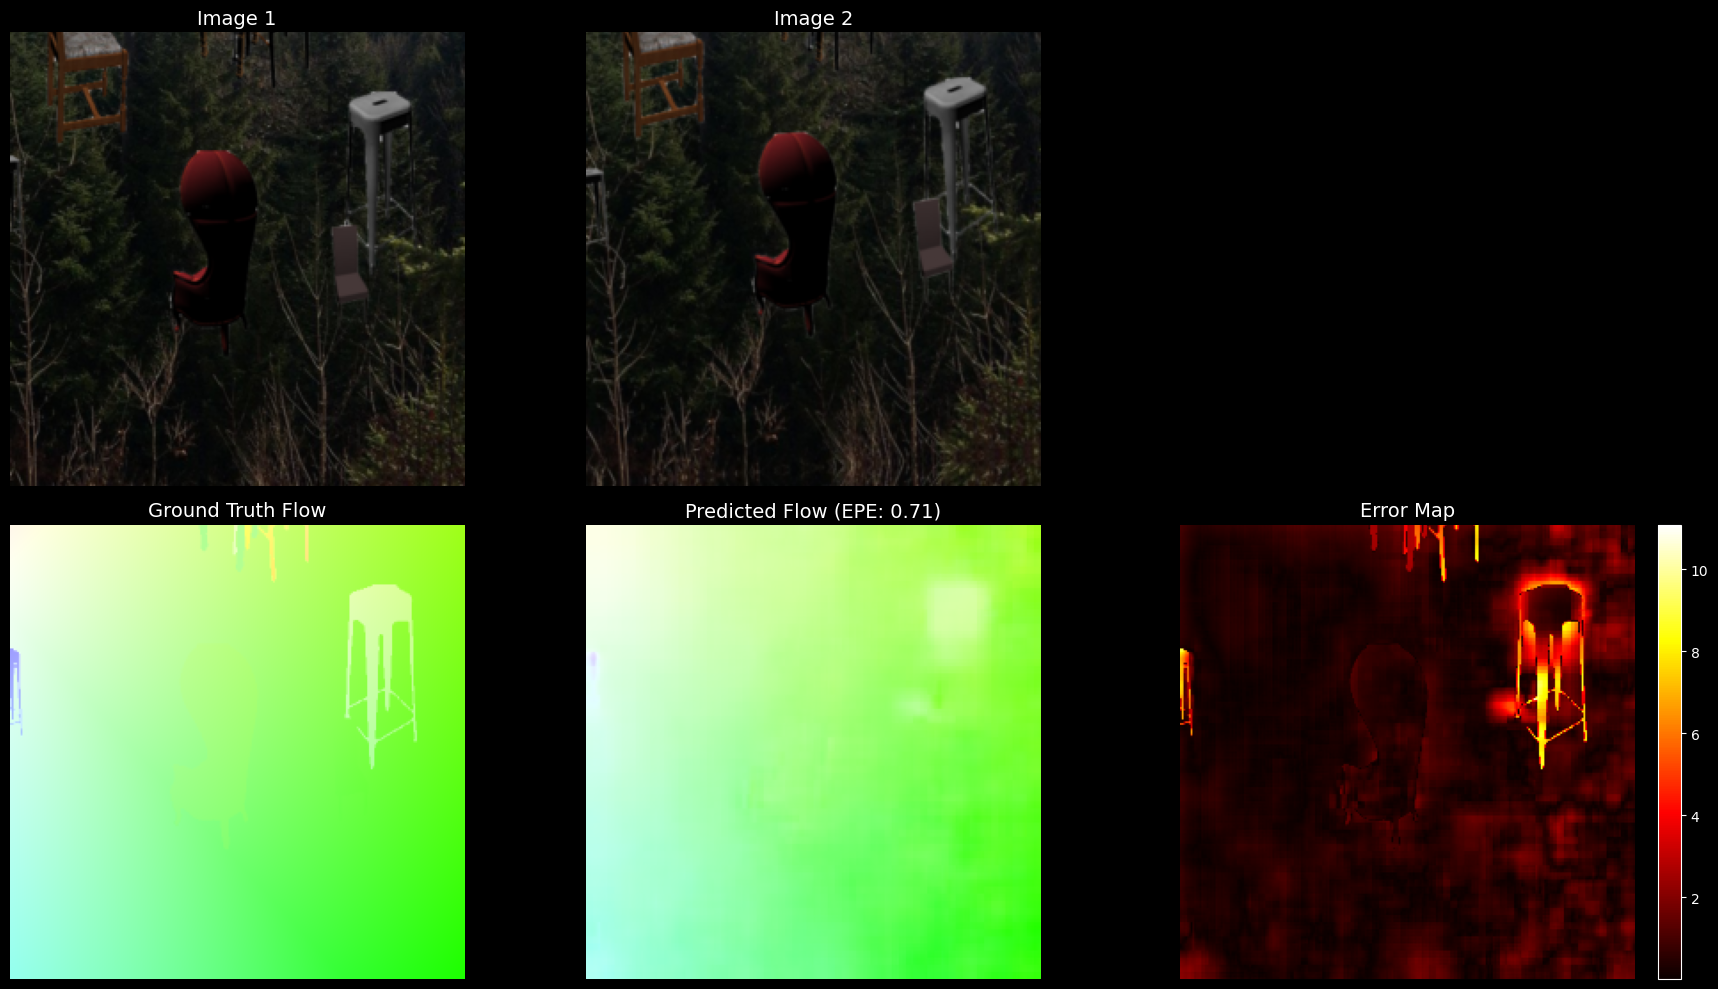

Average Endpoint Error: 0.7125 pixels


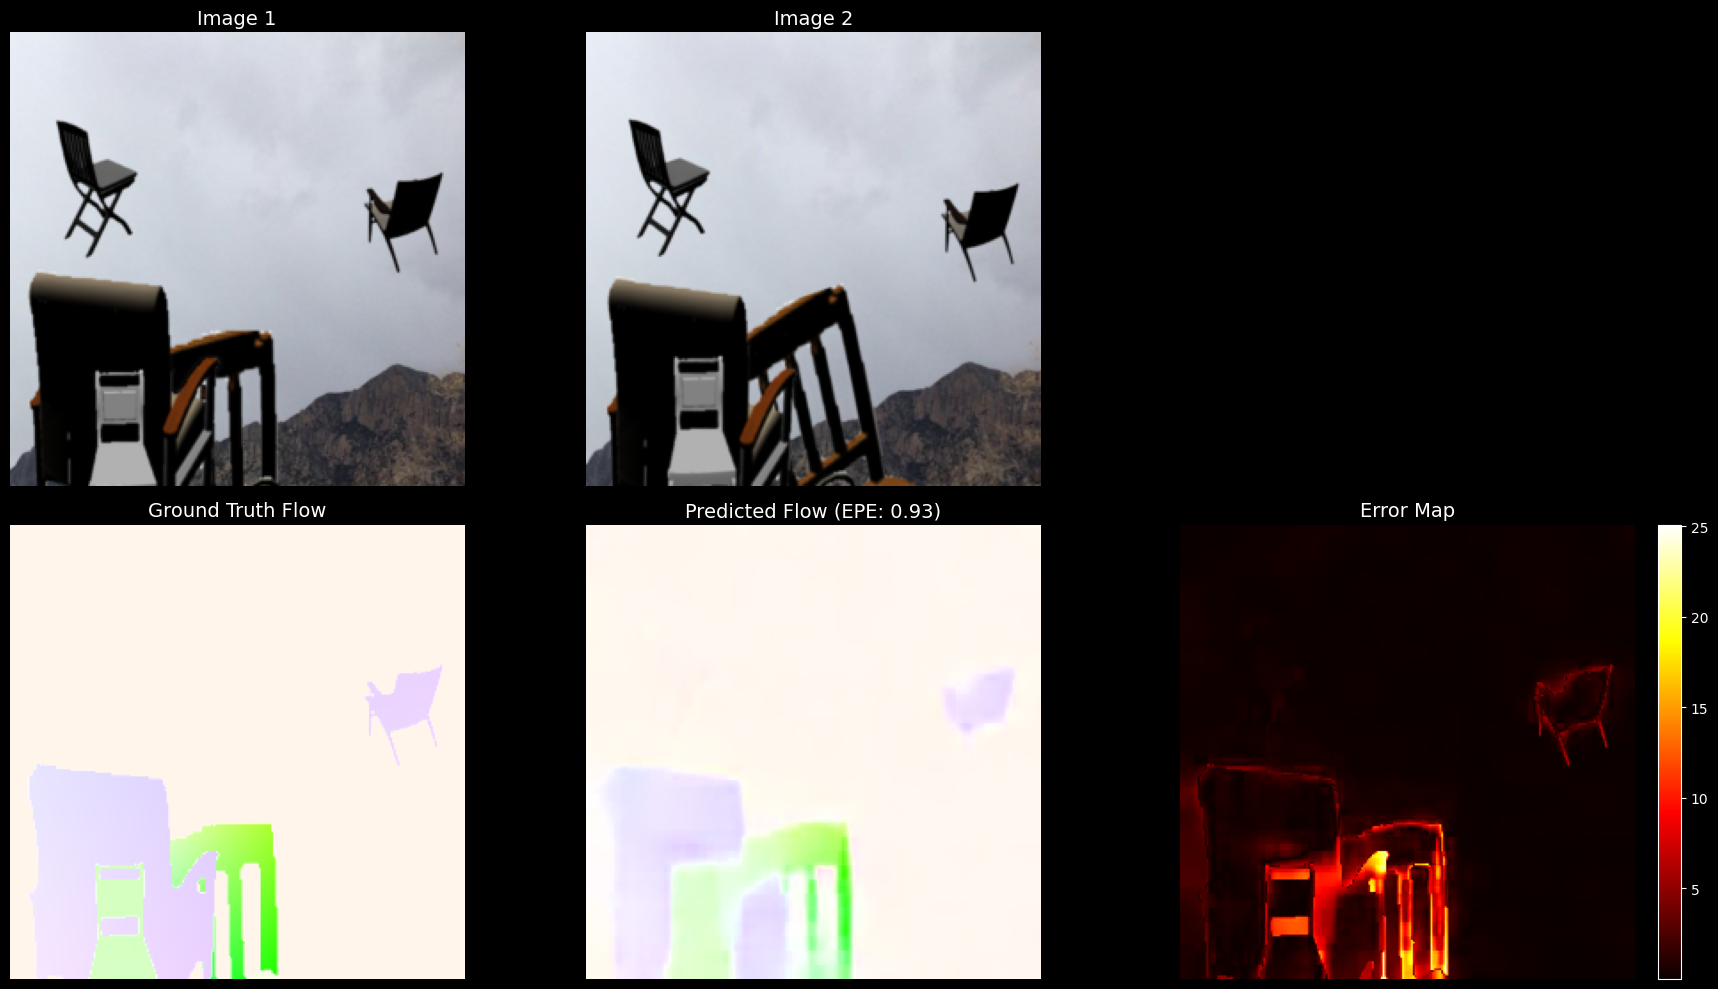

Average Endpoint Error: 0.9303 pixels


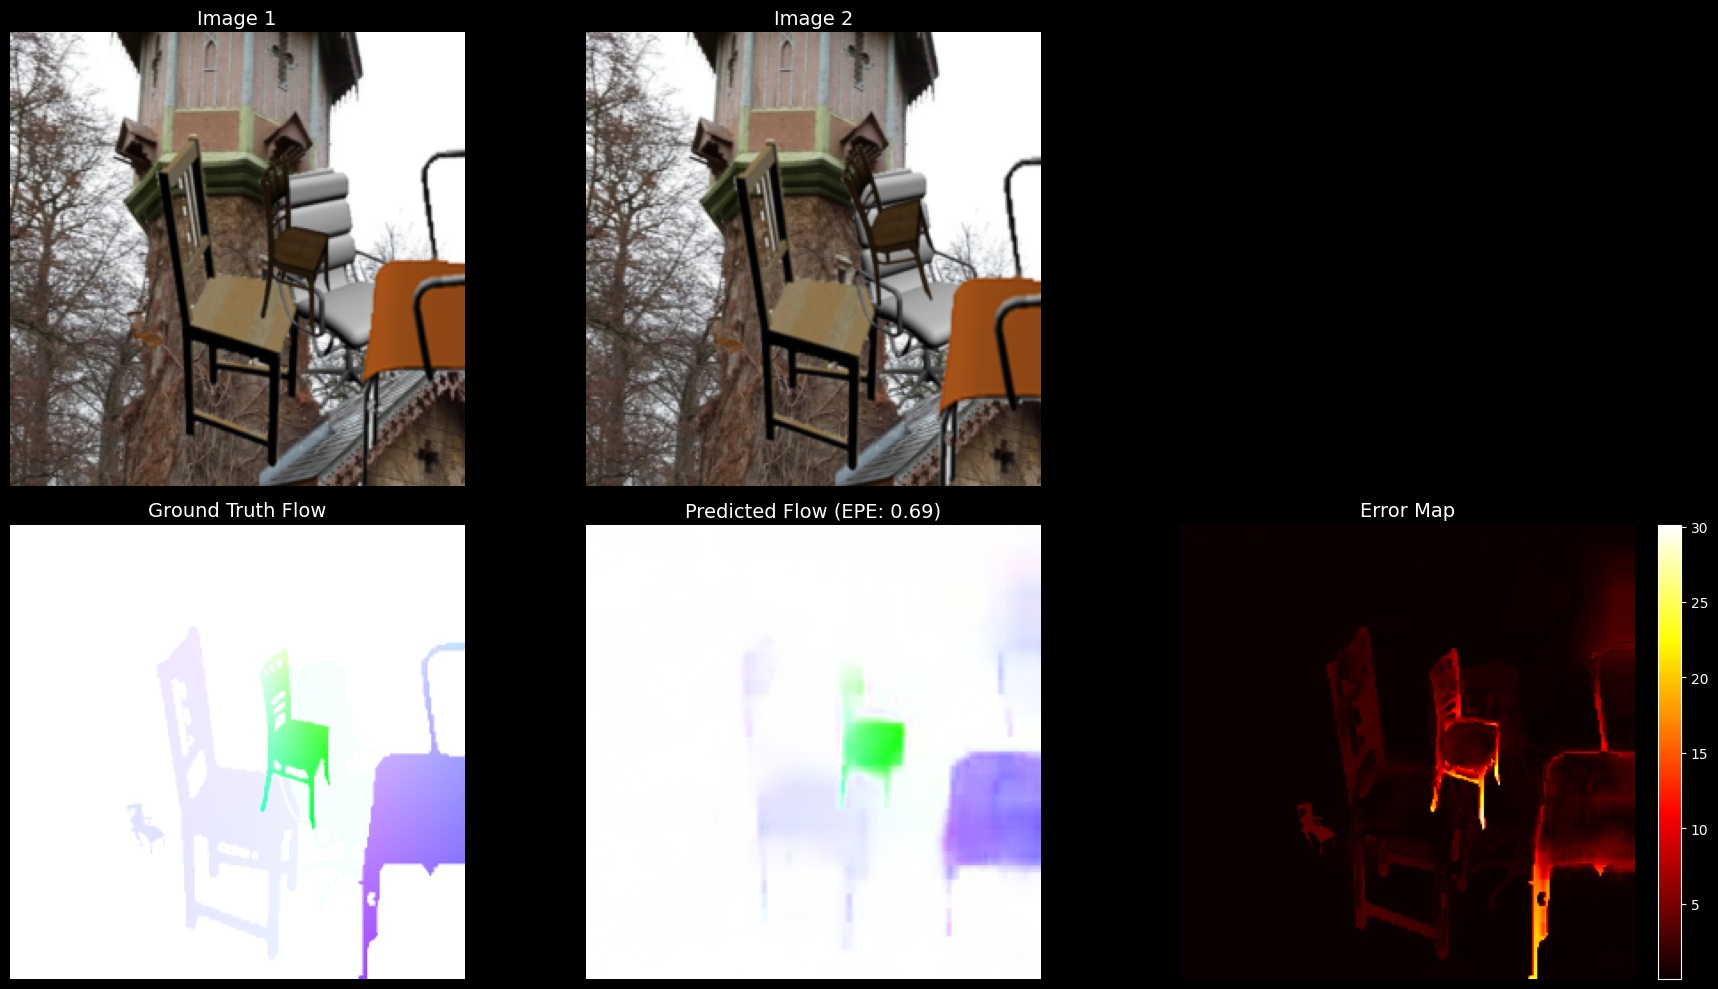

Average Endpoint Error: 0.6859 pixels


np.float32(0.6858964)

In [14]:
root = r"C:\Users\simon\Desktop\RV\Racunalniski-Vid\RV-N3\datasets\FlyingChairs_release"
checkpoint_dir = Path('./checkpoints')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = FlyingChairsDataset(root=root, transform=transform, split="train")

# Cell: Load best model and visualize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FlowNet().to(device)

best_model_path = checkpoint_dir / 'best_flownet_model.pth'
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from iteration {checkpoint['iteration']}")
print(f"Val Loss: {checkpoint['val_loss']:.4f}, Val EPE: {checkpoint['val_epe']:.4f}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Visualize predictions
visualize_flow_prediction(model, dataset, idx=random.randint(5, dataset.__len__()), device=device)
visualize_flow_prediction(model, dataset, idx=random.randint(5, dataset.__len__()), device=device)
visualize_flow_prediction(model, dataset, idx=random.randint(5, dataset.__len__()), device=device)

In [15]:
def plot_flow_data(img_data, flow_ref_data, flow_est_data=None):
    """
    Izris slik in optičnih pretokov na različnih nivojih.
    """
    img_cur = img_data[0, :3, :, :].detach().cpu().numpy().transpose(1, 2, 0)
    img_next = img_data[0, 3:, :, :].detach().cpu().numpy().transpose(1, 2, 0)

    # Izris slik
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(img_cur)
    ax[0].set_axis_off()
    ax[0].set_title('Trenutna slika')
    ax[1].imshow(img_next)
    ax[1].set_title('Naslednja slika')
    ax[1].set_axis_off()
    plt.tight_layout()
    plt.show()

    # Pripravi podatke za izris
    if flow_est_data is not None:
        n_rows = len(flow_ref_data)
        fig, ax = plt.subplots(n_rows, 2, squeeze=False, figsize=(12, 4 * n_rows))
        ax_data_pack = [
            (ax[:, 0], flow_ref_data, 'Ground Truth'),
            (ax[:, 1], flow_est_data, 'Predicted')
        ]
    else:
        n_rows = len(flow_ref_data)
        fig, ax = plt.subplots(n_rows, 1, squeeze=False, figsize=(6, 4 * n_rows))
        ax_data_pack = [(ax[:, 0], flow_ref_data, 'Ground Truth')]

    # Izris pretokov z 'nearest' interpolacijo
    for ax_list, flow_data, label in ax_data_pack:
        for n, f_img in enumerate(flow_data):
            f_img_viz = torchvision.utils.flow_to_image(f_img[0].detach().cpu())
            f_img_viz = f_img_viz.numpy().transpose(1, 2, 0)

            # Ključno: interpolation='nearest' za blokast izgled
            ax_list[n].imshow(f_img_viz, interpolation='nearest')
            ax_list[n].set_axis_off()

            h, w = f_img_viz.shape[:2]
            level = len(flow_data) - n
            ax_list[n].set_title(f'{label} - nivo {level}, ločljivost ({h}, {w})')

    plt.tight_layout()
    plt.show()


Sample 1/2 (dataset index: 8658)


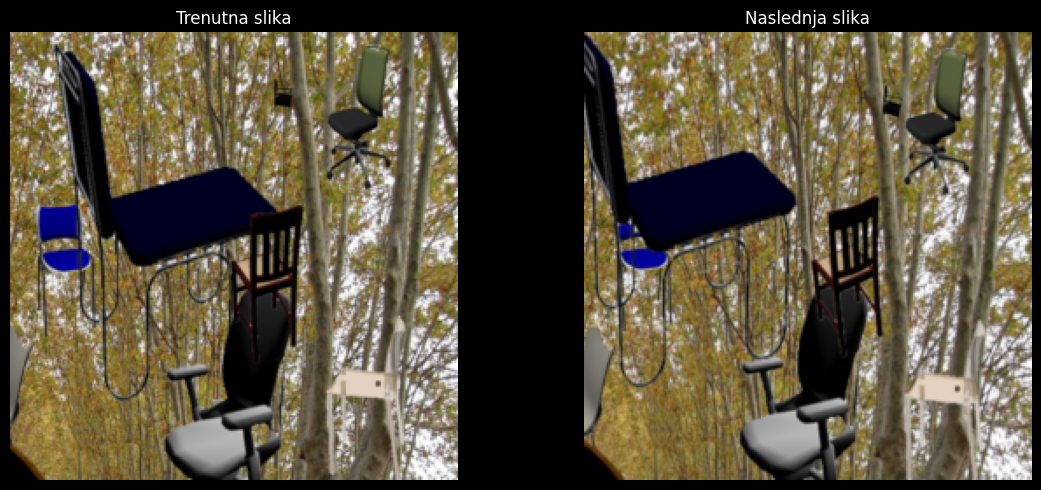

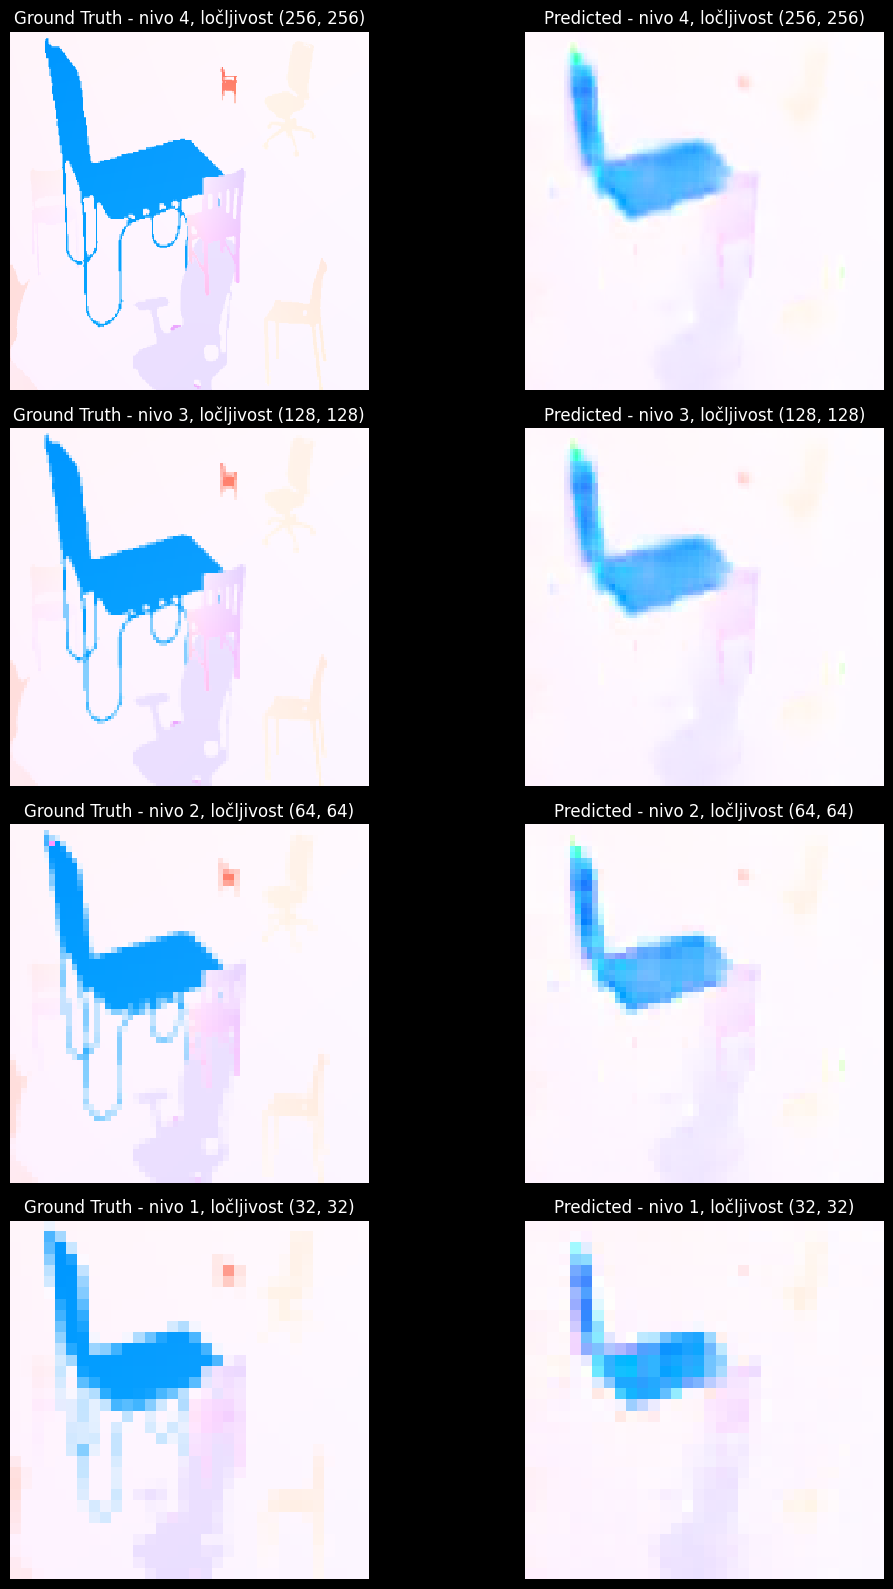


Sample 2/2 (dataset index: 8937)


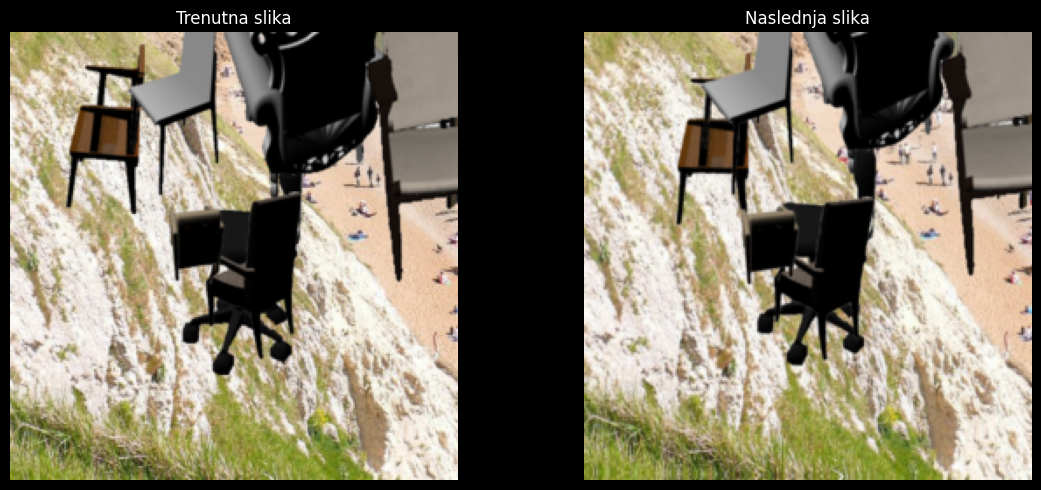

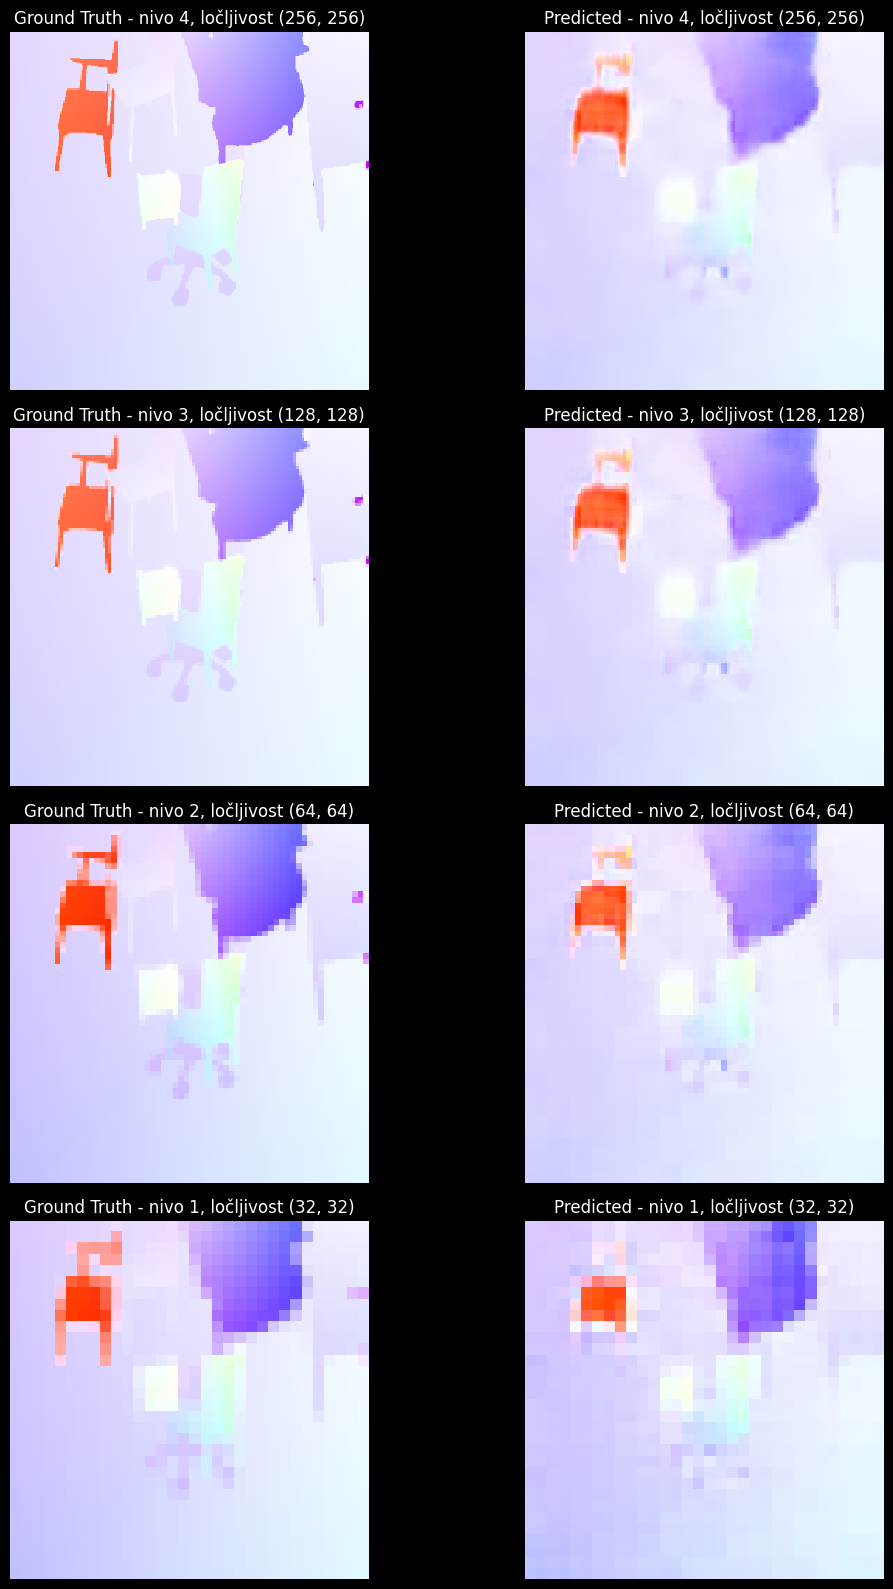

In [16]:
# Število random vzorcev za izris
n_samples = 2

for i in range(n_samples):
    # Pridobi random indeks
    random_idx = random.randint(0, len(dataset) - 1)
    print(f"\n{'=' * 60}")
    print(f"Sample {i + 1}/{n_samples} (dataset index: {random_idx})")
    print(f"{'=' * 60}")

    # Naloži podatke
    img_pair, flow_gt = dataset[random_idx]
    img_pair = img_pair.unsqueeze(0).to(device)
    flow_gt = flow_gt.unsqueeze(0).to(device)

    # Napoved
    model.eval()
    with torch.no_grad():
        flow1, flow2, flow3, flow4 = model(img_pair)

    # Pripravi GT na različnih nivojih (z area pooling)
    h, w = flow_gt.shape[2:]
    flow_gt_2 = F.interpolate(flow_gt, size=(h // 2, w // 2), mode='area')
    flow_gt_3 = F.interpolate(flow_gt, size=(h // 4, w // 4), mode='area')
    flow_gt_4 = F.interpolate(flow_gt, size=(h // 8, w // 8), mode='area')

    flow_gts = [flow_gt, flow_gt_2, flow_gt_3, flow_gt_4]
    flow_preds = [flow1, flow2, flow3, flow4]

    # Izris
    plot_flow_data(img_pair, flow_gts, flow_preds)

In [17]:
import torchinfo

# Cell: Load best model and visualize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FlowNet().to(device)

# checkpoint_dir = Path('./checkpoints')
# best_model_path = checkpoint_dir / 'best_flownet_model.pth'
# checkpoint = torch.load(best_model_path, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# print(f"Loaded model from iteration {checkpoint['iteration']}")
# print(f"Val Loss: {checkpoint['val_loss']:.4f}, Val EPE: {checkpoint['val_epe']:.4f}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

torchinfo.summary(model, depth=4)


Layer (type:depth-idx)                   Param #
FlowNet                                  --
├─DownBlock: 1-1                         --
│    └─ConvBlock: 2-1                    --
│    │    └─Sequential: 3-1              --
│    │    │    └─Conv2d: 4-1             18,880
│    │    │    └─BatchNorm2d: 4-2        128
│    │    │    └─ReLU: 4-3               --
│    └─ConvBlock: 2-2                    --
│    │    └─Sequential: 3-2              --
│    │    │    └─Conv2d: 4-4             200,768
│    │    │    └─BatchNorm2d: 4-5        128
│    │    │    └─ReLU: 4-6               --
│    └─MaxPool2d: 2-3                    --
├─DownBlock: 1-2                         --
│    └─ConvBlock: 2-4                    --
│    │    └─Sequential: 3-3              --
│    │    │    └─Conv2d: 4-7             204,928
│    │    │    └─BatchNorm2d: 4-8        256
│    │    │    └─ReLU: 4-9               --
│    └─ConvBlock: 2-5                    --
│    │    └─Sequential: 3-4              --
│    │    

# TESTING ON MPI-SINTEL

In [18]:
import cv2
from tqdm import tqdm
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import json


def evaluate_model_on_sintel(model, dataset, device='cuda', max_samples=None, cache_file=None):
    """
    Evaluate FlowNet on MPI Sintel dataset with checkpointing support

    Args:
        model: FlowNet model
        dataset: MPISintelDataset
        device: device to run on
        max_samples: limit number of samples (None = all)
        cache_file: path to save/load intermediate results (e.g., 'flownet_results.pkl')

    Returns:
        dict with EPE statistics
    """
    # Try to load cached results
    if cache_file and Path(cache_file).exists():
        print(f"Loading cached results from {cache_file}")
        with open(cache_file, 'rb') as f:
            cached_data = pickle.load(f)
        print(f"Loaded {len(cached_data['all_epes'])} cached EPE values")
        return cached_data

    model.eval()
    model = model.to(device)

    epes = []
    n_samples = len(dataset) if max_samples is None else min(max_samples, len(dataset))

    with torch.no_grad():
        for idx in tqdm(range(n_samples), desc="Evaluating FlowNet"):
            img_pair, flow_gt = dataset[idx]

            # Add batch dimension
            img_pair = img_pair.unsqueeze(0).to(device)
            flow_gt = flow_gt.to(device)

            # Predict
            flow_preds = model(img_pair)
            flow_pred = flow_preds[0]  # Full resolution
            flow_pred = flow_pred.squeeze(0)  # Remove batch dimension

            # Compute EPE
            epe = torch.norm(flow_pred - flow_gt, p=2, dim=0).mean().item()
            epes.append(epe)

    results = {
        'mean_epe': np.mean(epes),
        'median_epe': np.median(epes),
        'std_epe': np.std(epes),
        'min_epe': np.min(epes),
        'max_epe': np.max(epes),
        'all_epes': epes
    }

    # Save results to cache
    if cache_file:
        Path(cache_file).parent.mkdir(parents=True, exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(results, f)
        print(f"Results saved to {cache_file}")

    return results


In [19]:
def evaluate_farneback_on_sintel(dataset, max_samples=None,
                                 pyr_scale=0.5, levels=3, winsize=15,
                                 iterations=3, poly_n=5, poly_sigma=1.2,
                                 cache_file=None):
    """
    Evaluate Farneback optical flow on MPI Sintel with checkpointing support

    Args:
        dataset: MPISintelDataset
        max_samples: limit number of samples
        pyr_scale: pyramid scale (<1)
        levels: number of pyramid levels
        winsize: averaging window size
        iterations: number of iterations at each level
        poly_n: size of pixel neighborhood (5 or 7)
        poly_sigma: standard deviation of Gaussian for polynomial expansion
        cache_file: path to save/load intermediate results (e.g., 'farneback_default.pkl')

    Returns:
        dict with EPE statistics
    """
    # Try to load cached results
    if cache_file and Path(cache_file).exists():
        print(f"Loading cached results from {cache_file}")
        with open(cache_file, 'rb') as f:
            cached_data = pickle.load(f)
        print(f"Loaded {len(cached_data['all_epes'])} cached EPE values")
        return cached_data

    epes = []
    n_samples = len(dataset) if max_samples is None else min(max_samples, len(dataset))

    for idx in tqdm(range(n_samples), desc="Evaluating Farneback"):
        img_pair, flow_gt = dataset[idx]

        # Split images and convert to grayscale
        img1 = img_pair[:3].permute(1, 2, 0).cpu().numpy()
        img2 = img_pair[3:].permute(1, 2, 0).cpu().numpy()

        gray1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Compute flow
        flow_pred = cv2.calcOpticalFlowFarneback(
            gray1, gray2, None,
            pyr_scale=pyr_scale,
            levels=levels,
            winsize=winsize,
            iterations=iterations,
            poly_n=poly_n,
            poly_sigma=poly_sigma,
            flags=0
        )

        # Convert to torch and compute EPE
        flow_pred = torch.from_numpy(flow_pred).permute(2, 0, 1).float()

        epe = torch.norm(flow_pred - flow_gt, p=2, dim=0).mean().item()
        epes.append(epe)

    results = {
        'mean_epe': np.mean(epes),
        'median_epe': np.median(epes),
        'std_epe': np.std(epes),
        'min_epe': np.min(epes),
        'max_epe': np.max(epes),
        'all_epes': epes
    }

    # Save results to cache
    if cache_file:
        Path(cache_file).parent.mkdir(parents=True, exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(results, f)
        print(f"Results saved to {cache_file}")

    return results


In [20]:
sintel_root = r"C:\Users\simon\Desktop\RV\Racunalniski-Vid\RV-N3\datasets\MPI-Sintel-complete"

sintel_dataset = MPISintelDataset(
    root=sintel_root,
    split="training",
    pass_name="clean",
    resize_to=(448, 1024)
)
print(f"MPI Sintel training set size: {len(sintel_dataset)}")


MPI Sintel training set size: 1041


In [21]:
# Evaluate FlowNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint_dir = Path('./checkpoints')
model = FlowNet().to(device)
best_model_path = checkpoint_dir / 'best_flownet_model.pth'
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

print("Evaluating FlowNet on MPI Sintel...")
flownet_results = evaluate_model_on_sintel(
    model,
    sintel_dataset,
    device=device,
    cache_file='./checkpoints/flownet_sintel_results.pkl'
)

print(f"\n{'=' * 50}")
print("FlowNet Results on MPI Sintel:")
print(f"{'=' * 50}")
print(f"Mean EPE: {flownet_results['mean_epe']:.4f} pixels")
print(f"Median EPE: {flownet_results['median_epe']:.4f} pixels")
print(f"Std EPE: {flownet_results['std_epe']:.4f} pixels")
print(f"Min EPE: {flownet_results['min_epe']:.4f} pixels")
print(f"Max EPE: {flownet_results['max_epe']:.4f} pixels")


Evaluating FlowNet on MPI Sintel...


Evaluating FlowNet: 100%|██████████| 1041/1041 [15:32<00:00,  1.12it/s]

Results saved to ./checkpoints/flownet_sintel_results.pkl

FlowNet Results on MPI Sintel:
Mean EPE: 9.2158 pixels
Median EPE: 0.9251 pixels
Std EPE: 17.6222 pixels
Min EPE: 0.1467 pixels
Max EPE: 105.5678 pixels


In [22]:
# Test different Farneback parameters
print("\nTesting Farneback with different parameters...")

farneback_configs = [
    # (pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, name)
    (0.5, 3, 15, 3, 5, 1.2, "Default"),
    (0.5, 5, 15, 3, 5, 1.2, "More levels"),
    (0.5, 3, 21, 5, 7, 1.5, "Larger window"),
    (0.8, 5, 25, 5, 7, 1.5, "High quality"),
]

farneback_results = {}

for pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, name in farneback_configs:
    print(f"\nTesting: {name}")
    # Create unique cache filename based on config
    cache_filename = f"./checkpoints/farneback_{name.lower().replace(' ', '_')}.pkl"

    results = evaluate_farneback_on_sintel(
        sintel_dataset,
        max_samples=None,  # Use all samples
        pyr_scale=pyr_scale,
        levels=levels,
        winsize=winsize,
        iterations=iterations,
        poly_n=poly_n,
        poly_sigma=poly_sigma,
        cache_file=cache_filename
    )
    farneback_results[name] = results

    print(f"  Mean EPE: {results['mean_epe']:.4f} pixels")
    print(f"  Median EPE: {results['median_epe']:.4f} pixels")



Testing Farneback with different parameters...

Testing: Default


Evaluating Farneback: 100%|██████████| 1041/1041 [03:27<00:00,  5.01it/s]


Results saved to ./checkpoints/farneback_default.pkl
  Mean EPE: 10.4858 pixels
  Median EPE: 1.8283 pixels

Testing: More levels


Evaluating Farneback: 100%|██████████| 1041/1041 [03:26<00:00,  5.04it/s]


Results saved to ./checkpoints/farneback_more_levels.pkl
  Mean EPE: 10.4858 pixels
  Median EPE: 1.8283 pixels

Testing: Larger window


Evaluating Farneback: 100%|██████████| 1041/1041 [04:27<00:00,  3.89it/s]


Results saved to ./checkpoints/farneback_larger_window.pkl
  Mean EPE: 10.5189 pixels
  Median EPE: 2.0248 pixels

Testing: High quality


Evaluating Farneback: 100%|██████████| 1041/1041 [09:42<00:00,  1.79it/s]

Results saved to ./checkpoints/farneback_high_quality.pkl
  Mean EPE: 11.5487 pixels
  Median EPE: 2.0655 pixels


In [23]:
# Compare results
print(f"\n{'=' * 70}")
print("COMPARISON: FlowNet vs Farneback on MPI Sintel")
print(f"{'=' * 70}")

comparison_data = []

# Add FlowNet
comparison_data.append({
    'Method': 'FlowNet',
    'Mean EPE': flownet_results['mean_epe'],
    'Median EPE': flownet_results['median_epe'],
    'Std EPE': flownet_results['std_epe']
})

# Add Farneback configs
for name, results in farneback_results.items():
    comparison_data.append({
        'Method': f'Farneback ({name})',
        'Mean EPE': results['mean_epe'],
        'Median EPE': results['median_epe'],
        'Std EPE': results['std_epe']
    })

df = pd.DataFrame(comparison_data)
print(df.to_string(index=False))



COMPARISON: FlowNet vs Farneback on MPI Sintel
                   Method  Mean EPE  Median EPE   Std EPE
                  FlowNet  9.215762    0.925129 17.622222
      Farneback (Default) 10.485787    1.828255 18.225480
  Farneback (More levels) 10.485787    1.828255 18.225480
Farneback (Larger window) 10.518894    2.024751 17.834570
 Farneback (High quality) 11.548664    2.065476 19.290233


C:\Users\simon\AppData\Local\Temp\ipykernel_9600\866146755.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(all_epes, labels=methods)


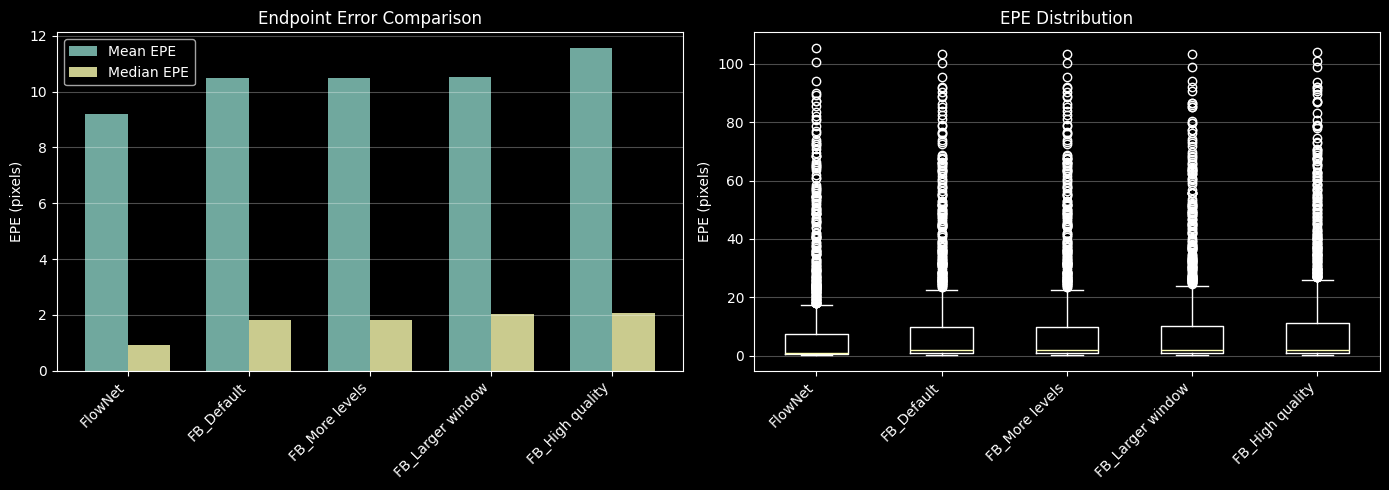

In [24]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['FlowNet'] + [f'FB_{name}' for name in farneback_results.keys()]
mean_epes = [flownet_results['mean_epe']] + [r['mean_epe'] for r in farneback_results.values()]
median_epes = [flownet_results['median_epe']] + [r['median_epe'] for r in farneback_results.values()]

x = np.arange(len(methods))
width = 0.35

axes[0].bar(x - width / 2, mean_epes, width, label='Mean EPE', alpha=0.8)
axes[0].bar(x + width / 2, median_epes, width, label='Median EPE', alpha=0.8)
axes[0].set_ylabel('EPE (pixels)')
axes[0].set_title('Endpoint Error Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
all_epes = [flownet_results['all_epes']] + [r['all_epes'] for r in farneback_results.values()]
axes[1].boxplot(all_epes, labels=methods)
axes[1].set_ylabel('EPE (pixels)')
axes[1].set_title('EPE Distribution')
axes[1].set_xticklabels(methods, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()